In [4]:
!pip install tensorflow

^C


--- Loading Project Artifacts for Evaluation ---


c:\Users\colli\miniconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Success: Model loaded from ../data/processed/lstm_fuel_model.h5
✅ Success: Scaler loaded from ../data/processed/minmax_scaler.pkl
✅ Success: Test data loaded. Features used: ['woodfuel_production_m3', 'temperature_avg', 'rainfall_mm', 'humidity_avg', 'woodfuel_lag7', 'temp_7d_avg', 'is_dry_season']
X_test shape: (548, 7, 7) | y_test shape: (548,)

--- Model Evaluation ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step

--- Performance Metrics (Unscaled Wood Fuel Demand) ---
Root Mean Squared Error (RMSE): 5,271.84 m³
Mean Absolute Error (MAE): 4,364.08 m³


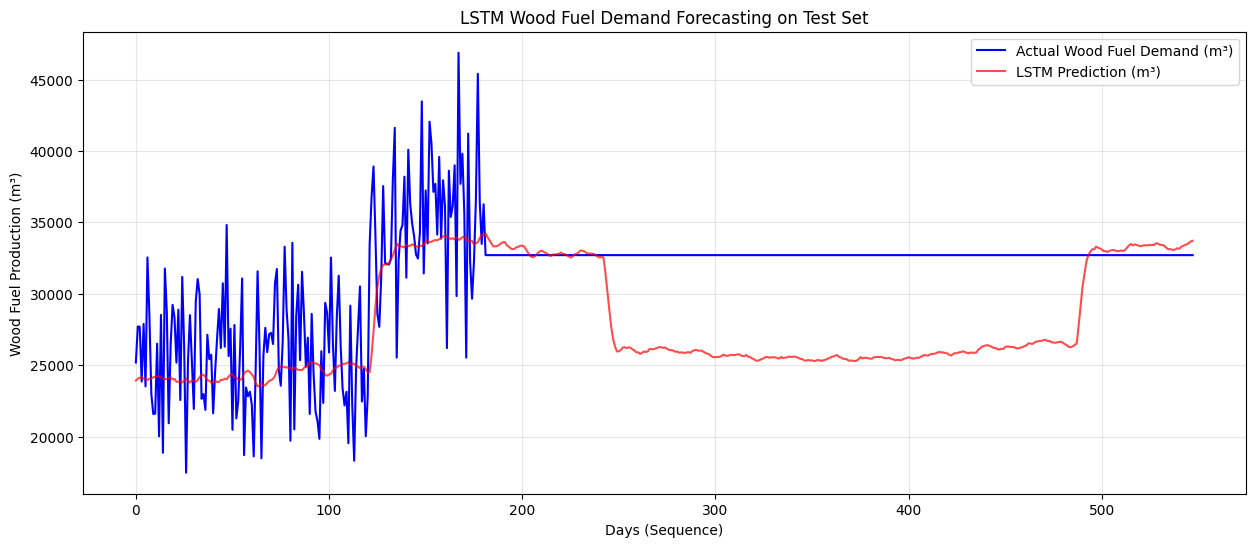


Evaluation complete! You should now see the RMSE and the prediction plot.


In [9]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import load_model
# IMPORT the specific modules Keras needs for deserialization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as KerasMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# --- 1. CORRECTED CONFIGURATION (The paths are correct now) ---
MODEL_PATH = '../data/processed/lstm_fuel_model.h5'
SCALER_PATH = '../data/processed/minmax_scaler.pkl'
TEST_DATA_PATH = '../data/processed/test_data_for_evaluation.pkl'

TARGET_FEATURE_INDEX = 0

# --- 2. LOAD ARTIFACTS ---

print("--- Loading Project Artifacts for Evaluation ---")

try:
    # --- CRITICAL FIX: Add custom_objects ---
    # We pass the required Keras objects that the model needs to reload its compile configuration.
    CUSTOM_OBJECTS = {
        'loss': MeanSquaredError, 
        'mse': KerasMSE 
    }
    
    loaded_model = load_model(MODEL_PATH, custom_objects=CUSTOM_OBJECTS)
    print(f"✅ Success: Model loaded from {MODEL_PATH}")

    # Load the MinMaxScaler 
    data_scaler = joblib.load(SCALER_PATH)
    print(f"✅ Success: Scaler loaded from {SCALER_PATH}")

    # Load the test data dictionary
    test_artifacts = joblib.load(TEST_DATA_PATH)
    
    # Extract the data
    X_test = test_artifacts['X_test']
    y_test = test_artifacts['y_test']
    feature_cols = test_artifacts['feature_cols']

    print(f"✅ Success: Test data loaded. Features used: {feature_cols}")
    print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")
    
except Exception as e:
    print(f"❌ CRITICAL ERROR: An error occurred during file loading.")
    print(f"Error details: {e}")
    # Display current working directory to help debug path issues if the error returns
    print(f"Current Directory: {os.getcwd()}")
    raise

# --- 3. BEGIN EVALUATION (Rest of the code remains the same) ---

print("\n--- Model Evaluation ---")

# a. Make predictions on the test set
# The rest of your code is already correct for evaluation, unscaling, and plotting!

scaled_predictions = loaded_model.predict(X_test)

# b. Inverse Transform (Unscale) the True Test Values (y_test) and Predictions
y_test_unscaled_matrix = np.zeros((len(y_test), len(feature_cols)))
y_test_unscaled_matrix[:, TARGET_FEATURE_INDEX] = y_test
y_test_actual = data_scaler.inverse_transform(y_test_unscaled_matrix)[:, TARGET_FEATURE_INDEX]

predictions_unscaled_matrix = np.zeros((len(scaled_predictions), len(feature_cols)))
predictions_unscaled_matrix[:, TARGET_FEATURE_INDEX] = scaled_predictions[:, 0]
predictions_actual = data_scaler.inverse_transform(predictions_unscaled_matrix)[:, TARGET_FEATURE_INDEX]

# --- 4. CALCULATE PERFORMANCE METRICS ---

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)

print(f"\n--- Performance Metrics (Unscaled Wood Fuel Demand) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} m³")
print(f"Mean Absolute Error (MAE): {mae:,.2f} m³")

# --- 5. VISUALIZE RESULTS ---

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Wood Fuel Demand (m³)', color='blue')
plt.plot(predictions_actual, label='LSTM Prediction (m³)', color='red', alpha=0.7)

plt.title('LSTM Wood Fuel Demand Forecasting on Test Set')
plt.xlabel('Days (Sequence)')
plt.ylabel('Wood Fuel Production (m³)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nEvaluation complete! You should now see the RMSE and the prediction plot.")